# Yiming's POP variance budget

Reproducing the variance budget for POP

In [1]:
%load_ext watermark
%matplotlib inline

import glob

import cf_xarray as cfxr
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from IPython.display import Image

import eddydiff as ed
import xarray as xr

xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 200
plt.style.use("bmh")

%watermark -iv

dcpy       : 0.1
cf_xarray  : 0.5.3.dev29+g3660810.d20210729
distributed: 2021.10.0
eddydiff   : 0.1
xarray     : 0.17.1.dev3+g48378c4b1
tqdm       : 4.62.3
numpy      : 1.21.3
matplotlib : 3.4.3



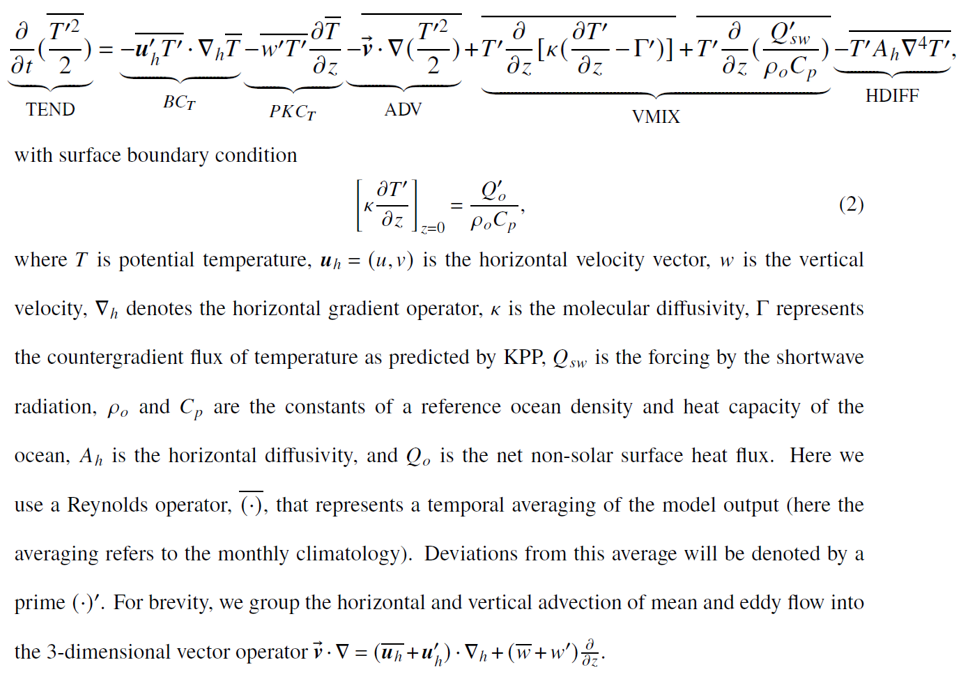

In [79]:
Image("../yiming-budget.png")

In [19]:
pop = xr.open_dataset("../datasets/pop-variance-budget.zarr", engine="zarr")
pop["depth"] = pop.depth * 100
pop

<xarray.Dataset>
Dimensions:  (depth: 62, lat: 2400, lon: 3600)
Coordinates:
    TLAT     (lat, lon) float64 ...
    TLONG    (lat, lon) float64 ...
  * depth    (depth) float64 5.0 15.0 25.0 ... 5.375e+03 5.625e+03 5.875e+03
Dimensions without coordinates: lat, lon
Data variables:
    BC       (depth, lat, lon) float64 ...
    HDIFF    (depth, lat, lon) float64 ...
    PKC      (depth, lat, lon) float64 ...
    VMIX     (depth, lat, lon) float64 ...

In [20]:
pop_natre = pop.isel(lat=slice(1420, 1472), lon=slice(790, 840))
pop_natre_mean = pop_natre.mean(["lat", "lon"])
pop_natre

<xarray.Dataset>
Dimensions:  (depth: 62, lat: 52, lon: 50)
Coordinates:
    TLAT     (lat, lon) float64 ...
    TLONG    (lat, lon) float64 ...
  * depth    (depth) float64 5.0 15.0 25.0 ... 5.375e+03 5.625e+03 5.875e+03
Dimensions without coordinates: lat, lon
Data variables:
    BC       (depth, lat, lon) float64 3.882e-09 3.784e-09 3.951e-09 ... nan nan
    HDIFF    (depth, lat, lon) float64 -4.868e-11 -1.124e-10 ... nan nan
    PKC      (depth, lat, lon) float64 9.889e-10 1.025e-09 9.864e-10 ... nan nan
    VMIX     (depth, lat, lon) float64 -3.805e-09 -3.443e-09 ... nan nan

(array([1.500e+01, 4.400e+01, 1.960e+02, 6.020e+02, 1.116e+03, 1.671e+03,
        2.714e+03, 5.089e+03, 9.865e+03, 8.494e+04]),
 array([-2.29686765e-08, -2.06718089e-08, -1.83749412e-08, -1.60780736e-08,
        -1.37812059e-08, -1.14843383e-08, -9.18747061e-09, -6.89060296e-09,
        -4.59373531e-09, -2.29686765e-09, -3.01649236e-20]),
 <BarContainer object of 10 artists>)

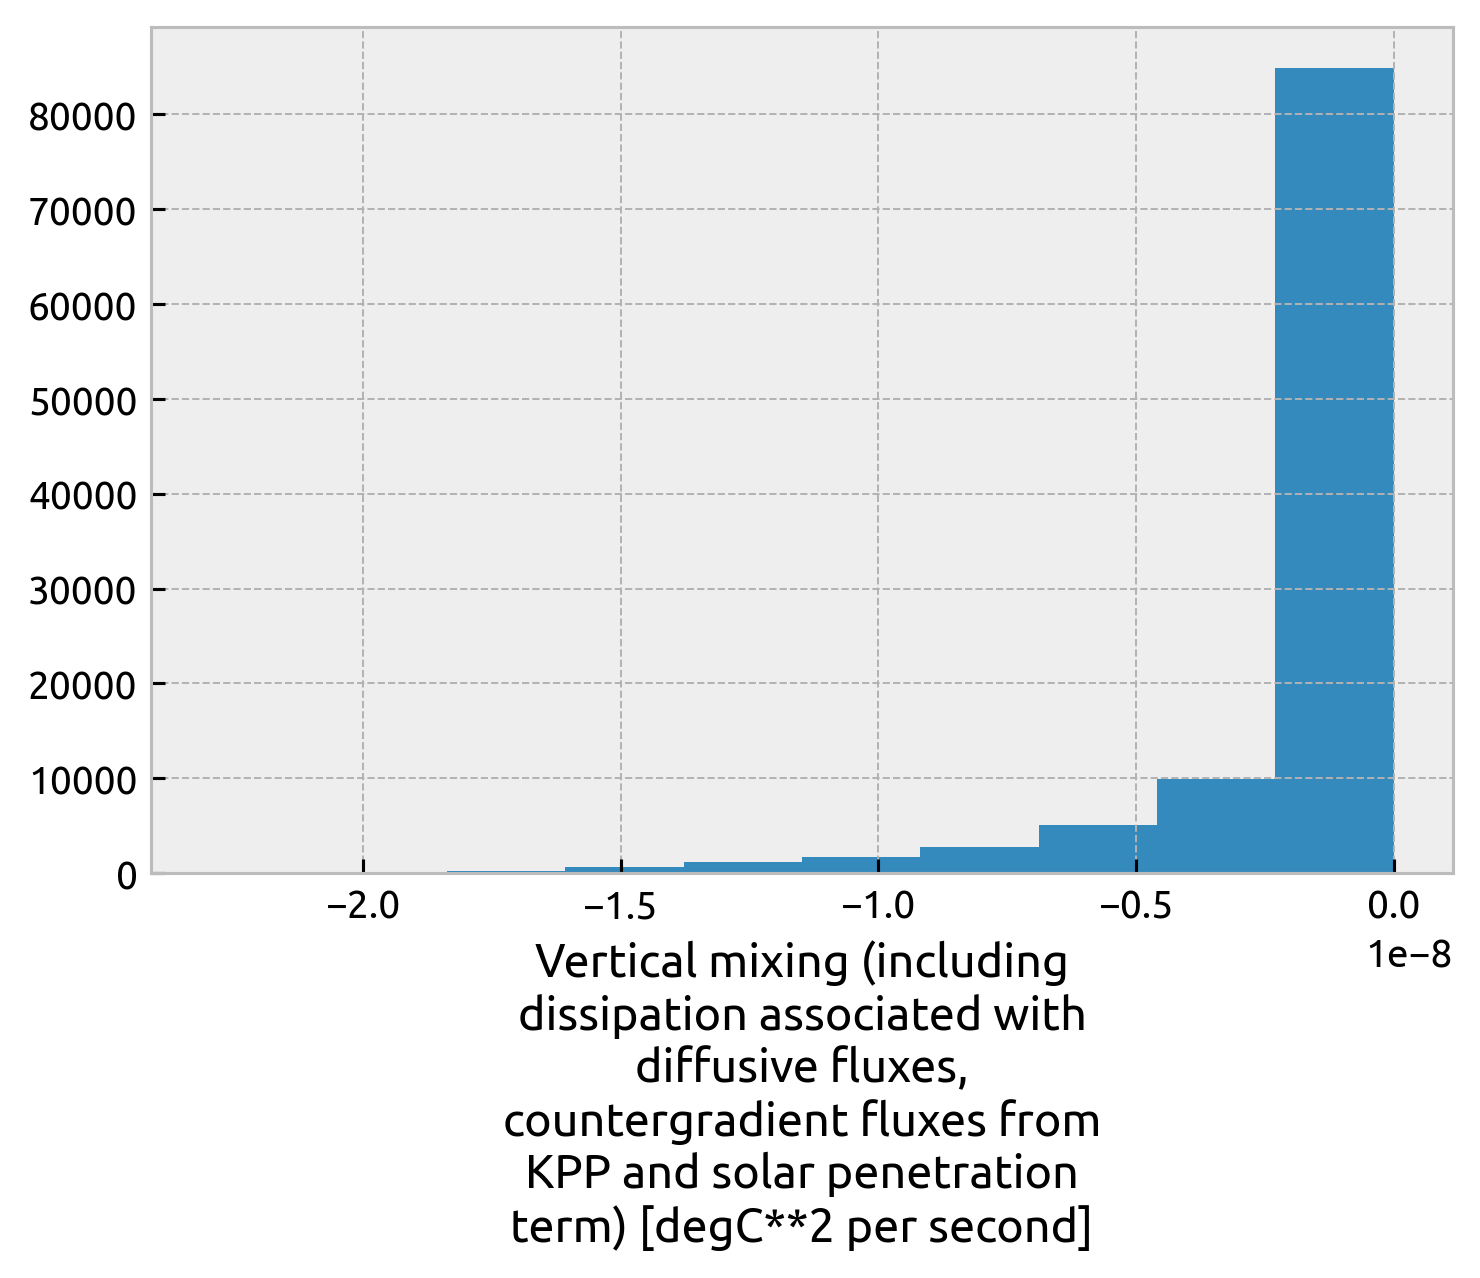

In [12]:
pop_natre.VMIX.where(pop_natre.VMIX < 0).plot.hist()

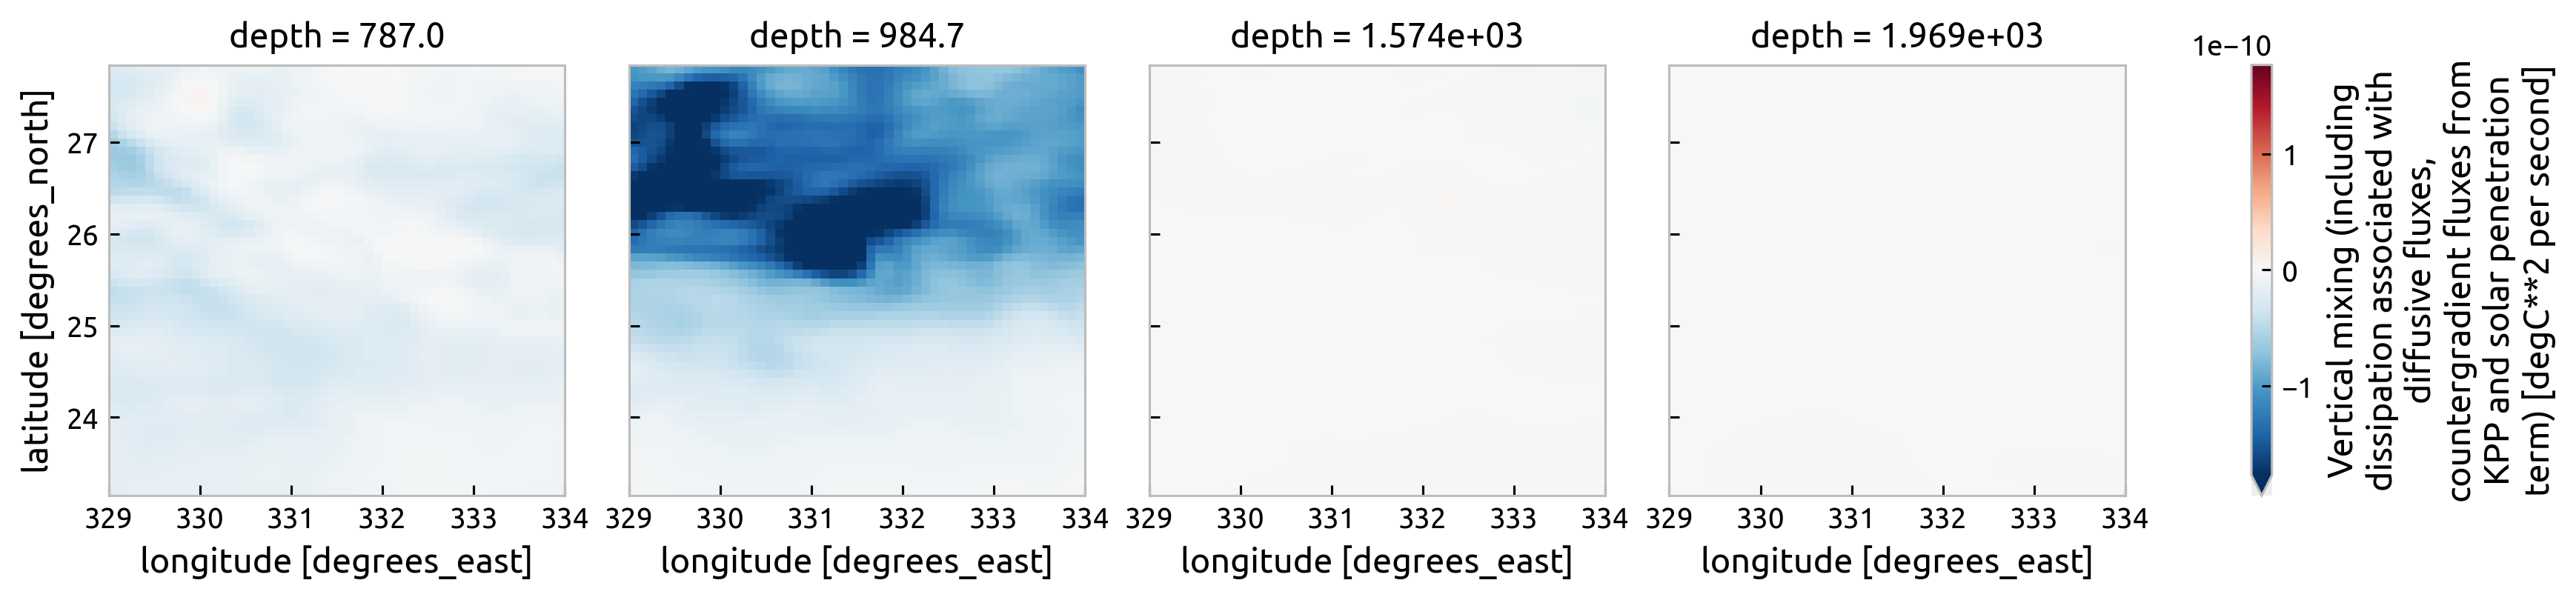

In [22]:
vmix.sel(depth=[750, 1000, 1500, 2000], method="nearest").plot(
    col="depth", x="TLONG", y="TLAT", robust=True
)

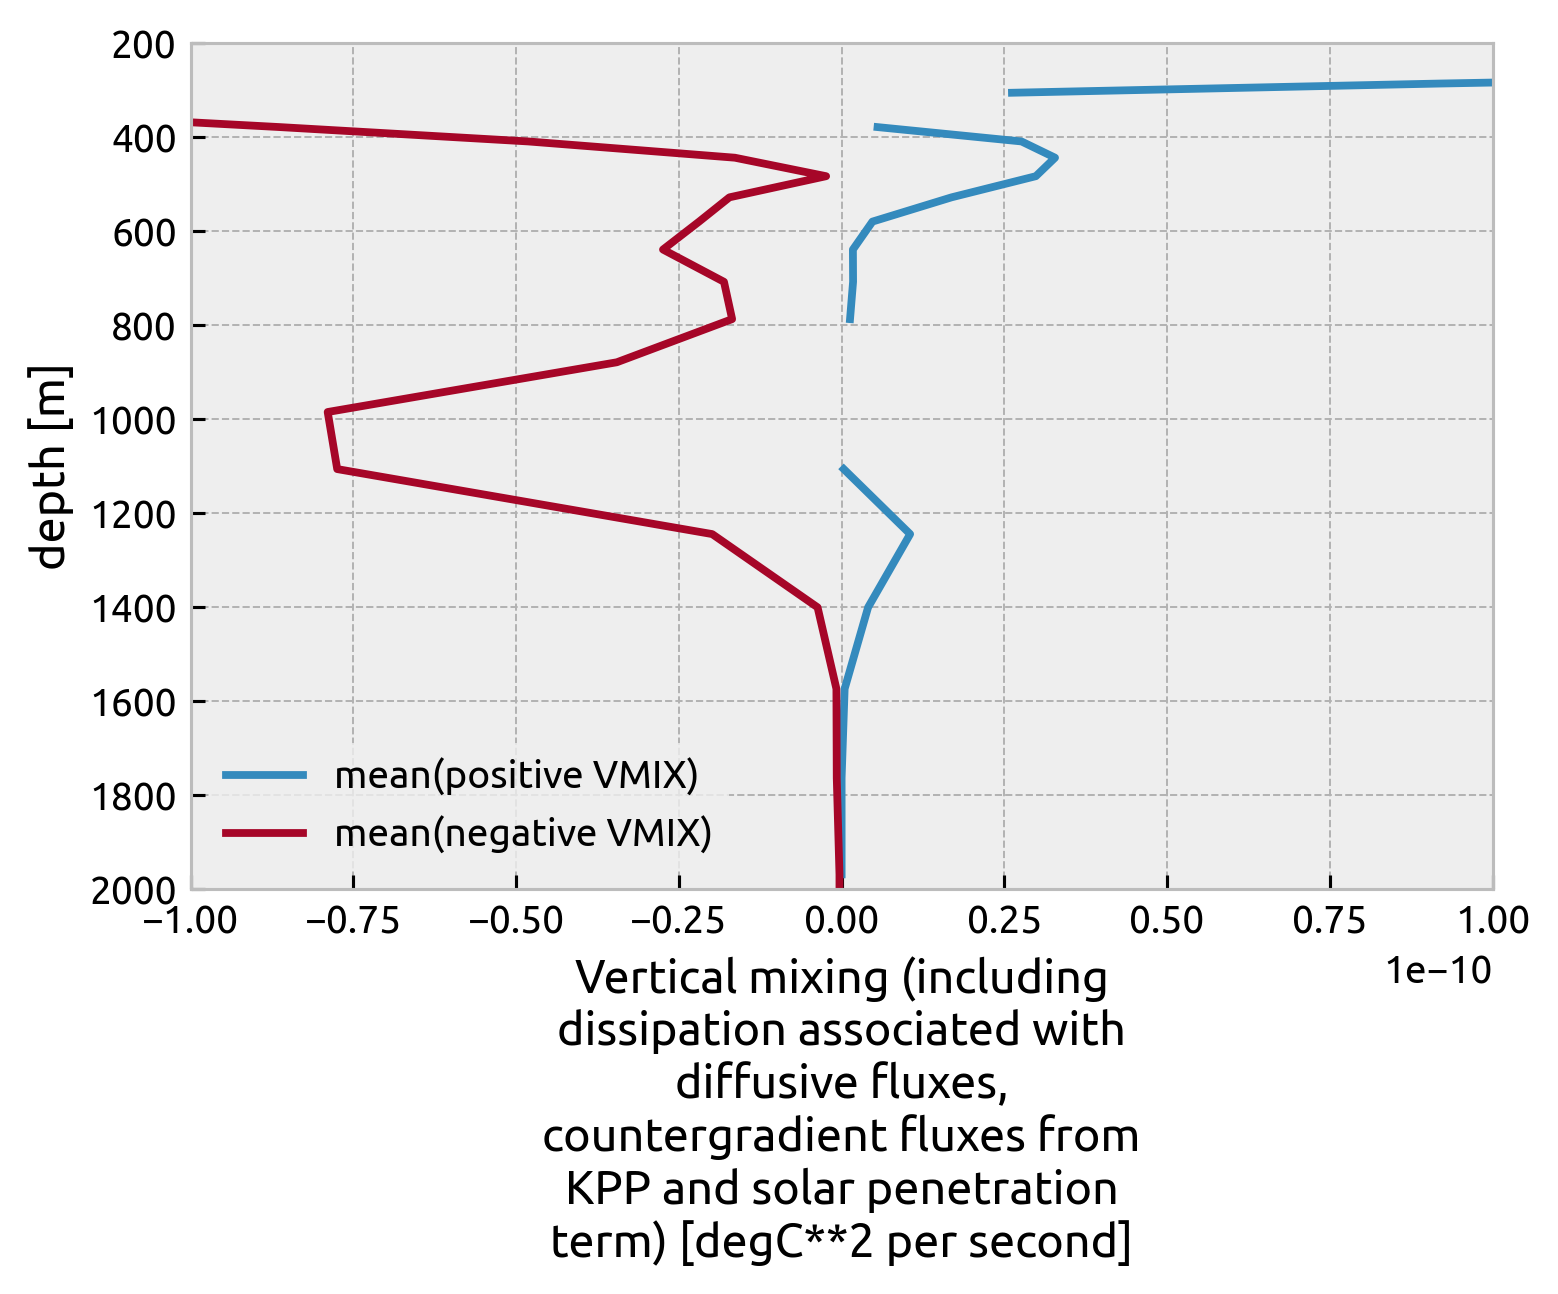

In [24]:
vmix = pop_natre.VMIX
vmix.where(vmix > 0).mean(["lat", "lon"]).cf.plot()
vmix.where(vmix < 0).mean(["lat", "lon"]).cf.plot(
    ylim=(2000, 200), xlim=(-1e-10, 1e-10)
)
plt.legend(["mean(positive VMIX)", "mean(negative VMIX)"])

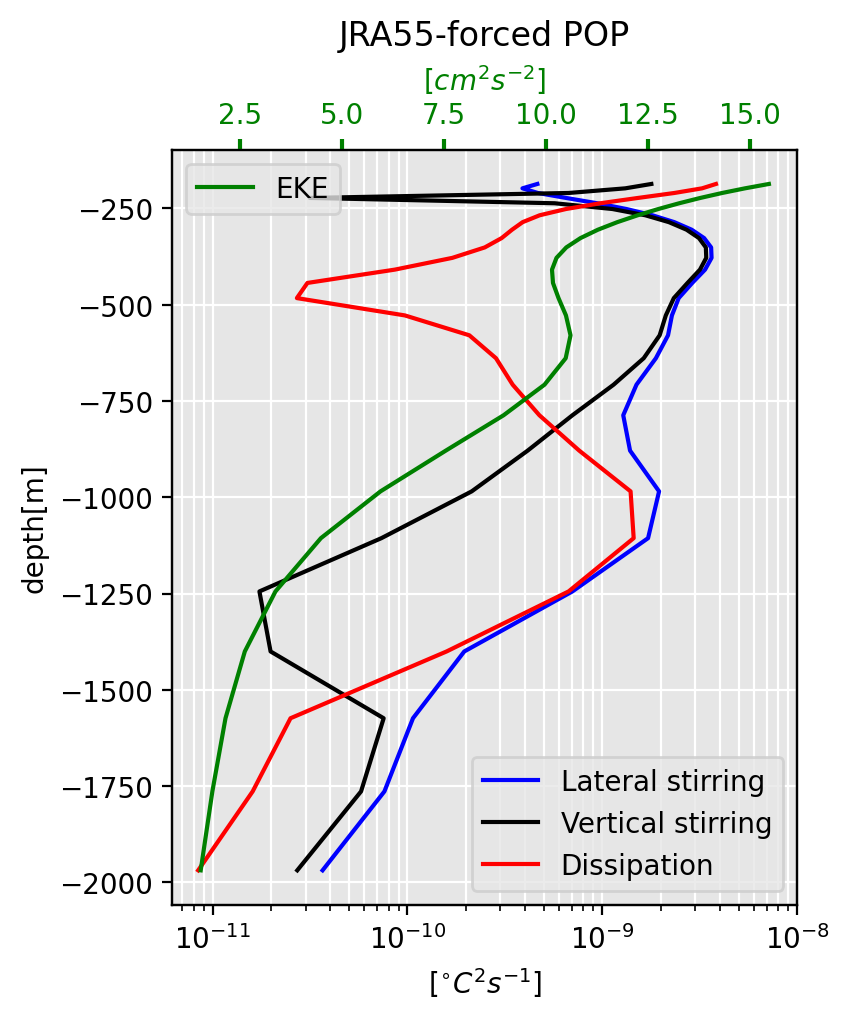

In [44]:
Image("../images/Tvariance_budget_NATREregion_with_EKE.png", width=400)

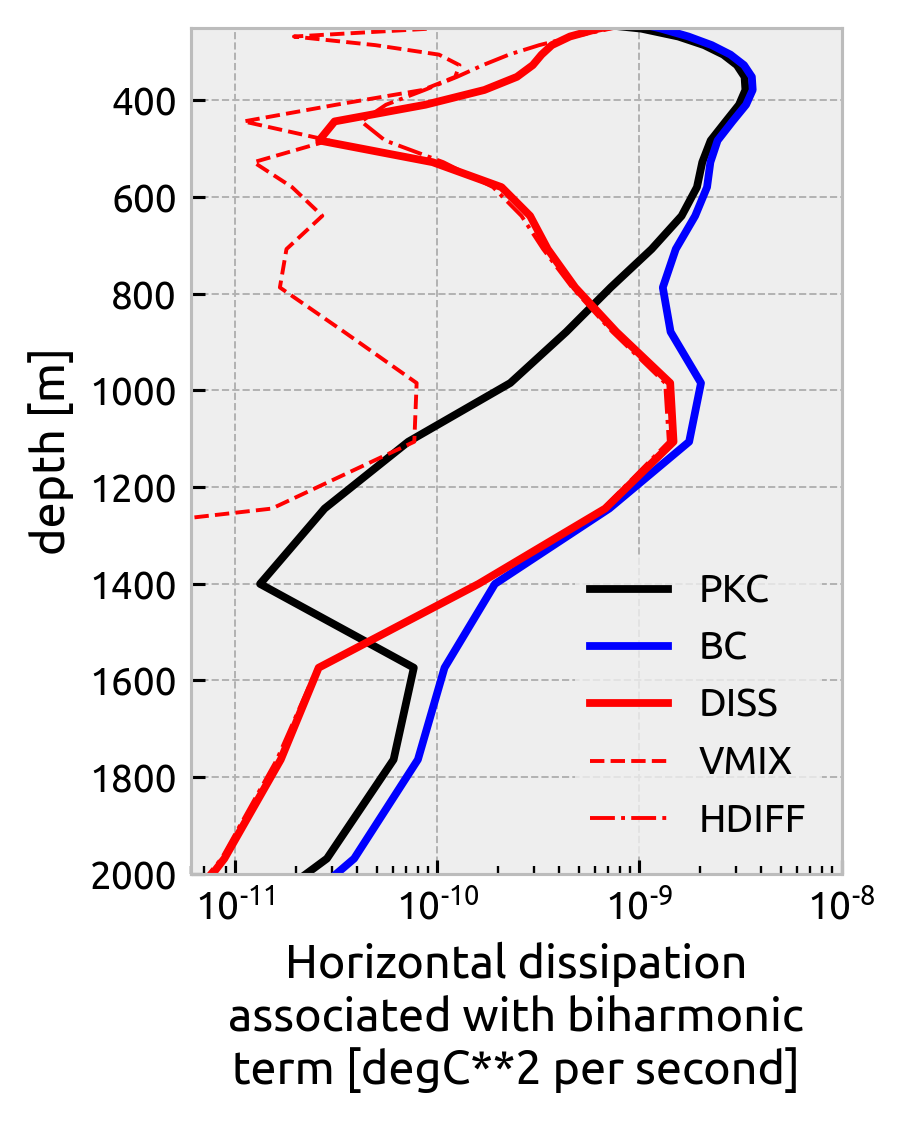

In [40]:
# pop_natre_mean["VMIX"] = pop_natre.VMIX.where(pop_natre.VMIX < 0).mean(["lat", "lon"])
pop_natre_mean["DISS"] = pop_natre_mean.VMIX + pop_natre_mean.HDIFF
pop_natre_mean.DISS.attrs = {
    "units": "degC**2 per second",
    "long_name": "Total dissipation",
    "description": "sum of VMIX and HDIFF",
}

for var, color in zip(["PKC", "BC", "DISS"], ["k", "b", "r"]):
    np.abs(pop_natre_mean[var]).cf.plot(
        label=var,
        ylim=(2000, 250),
        xscale="log",
        xlim=(6e-12, 1e-8),
        color=color,
    )

np.abs(pop_natre_mean.VMIX).cf.plot(label="VMIX", color="r", ls="--", lw=1)
np.abs(pop_natre_mean.HDIFF).cf.plot(label="HDIFF", color="r", ls="-.", lw=1)
plt.legend()
plt.gcf().set_size_inches((3, 4))

In [42]:
pop_natre_mean.to_netcdf("../datasets/natre-pop-variance.nc")